In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white', {'xtick.bottom': True, 'ytick.left': True})
sns.set_context('notebook', font_scale=2)

In [2]:
# color scheme for figures
import visual_behavior.ophys.response_analysis.utilities as ut
colors = ut.get_colors_for_image_sets()

In [3]:
# pointer to saved results directory for experiments and models
experiment_dir = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_pilot_analysis/visual_behavior_pilot_manuscript_initial_submission/'
model_dir = '/allen/programs/braintv/workgroups/cortexmodels/brianh/exps/stsp_final/noise_std_0.5_pos_weight_5_l2_pen_0.001_patience_5/RESULT/'

# New function to compute d-prime

In [4]:
def trial_number_limit(p, N):
    if N == 0:
        return np.nan
    else:
        p = np.max((p, 1. / (2 * N)))
        p = np.min((p, 1 - 1. / (2 * N)))
    return p

In [5]:
from scipy.stats import norm

def compute_dprime(hit_rate, fa_rate, go_trials, catch_trials, total_trials):
    """ calculates the d-prime for a given hit rate and false alarm rate
    https://en.wikipedia.org/wiki/Sensitivity_index
    Parameters
    ----------
    hit_rate : float
    rate of hits in the True class
    fa_rate : float
    rate of false alarms in the False class
    go_trials: int
    number of go trials
    catch_trials: int
    number of catch trials
    total_trials: int
    total number of trials
    Returns
    -------
    d_prime
    """
    limits = (1./total_trials, 1 - 1./total_trials)
    assert limits[0] > 0.0, 'limits[0] must be greater than 0.0'
    assert limits[1] < 1.0, 'limits[1] must be less than 1.0'
    assert (go_trials + catch_trials) == total_trials
    Z = norm.ppf
    # Limit values in order to avoid d' infinity
    hit_rate = np.clip(trial_number_limit(hit_rate, go_trials), limits[0], limits[1])
    fa_rate = np.clip(trial_number_limit(fa_rate, catch_trials), limits[0], limits[1])
    return Z(hit_rate) - Z(fa_rate)

# D-prime

## Experiment

In [7]:
df = pd.read_hdf(os.path.join(experiment_dir, 'multi_session_summary_dfs', 'response_rate_summary_df_engaged.h5'))

In [8]:
# choose image set A and Slc experiments
df_subset = df[(df.image_set=='A')&(df.cre_line=='Slc17a7-IRES2-Cre')]

In [9]:
# recompute dprime over whole session
df_subset.loc[:, 'dprime'] = [compute_dprime(hr, far, go, catch, total) for hr, far, go, catch, total in zip(df_subset.hit_rate.values, df_subset.catch_fa_rate.values, df_subset.n_change_trials, (df_subset.total_trials-df_subset.n_aborted_trials-df_subset.n_change_trials), (df_subset.total_trials-df_subset.n_aborted_trials))]

/home/brianh/miniconda3/envs/vis-behav/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/brianh/miniconda3/envs/vis-behav/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Models

In [13]:
model_dict = {}
for model in ['STSPNet', 'RNN']:
    model_dict[model] = {}
    model_dict[model]['dprime'] = []
    model_dict[model]['hr'] = []
    model_dict[model]['far'] = []
    for seed in range(1,11):
        temp = pickle.load(open(model_dir+model+'/'+model+'_A_'+str(seed)+'.pkl', 'rb'))
        model_dict[model]['dprime'].append(temp['dprime'])
        model_dict[model]['hr'].append(temp['hr'])
        model_dict[model]['far'].append(temp['far'])
    model_dict[model]['dprime'] = np.array(model_dict[model]['dprime'])
    model_dict[model]['hr'] = np.array(model_dict[model]['hr'])
    model_dict[model]['far'] = np.array(model_dict[model]['far'])

In [11]:
# create one dataframe
exp_df = pd.DataFrame({'model': 'Experiment', 'dprime': df_subset.dprime.values, 'hr': df_subset.hit_rate.values, 'far': df_subset.catch_fa_rate.values})
stspnet_df = pd.DataFrame({'model': 'STPNet', 'dprime': model_dict['STSPNet']['dprime'], 'hr': model_dict['STSPNet']['dprime'], 'far': model_dict['STSPNet']['dprime']})
rnn_df = pd.DataFrame({'model': 'RNN', 'dprime': model_dict['RNN']['dprime'], 'hr': model_dict['RNN']['dprime'], 'far': model_dict['RNN']['dprime']})

df_all = pd.concat((exp_df, stspnet_df, rnn_df), ignore_index=True)

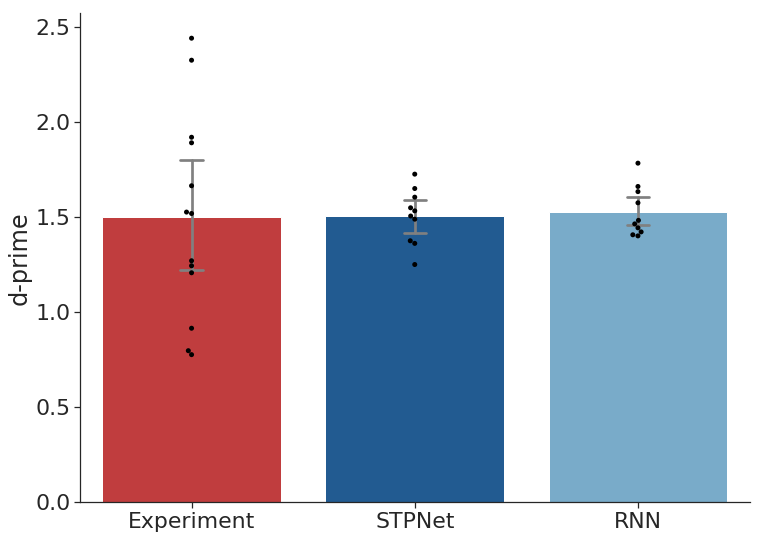

In [12]:
fig, ax = plt.subplots(1,1,figsize=(12,9))

sns.barplot(x='model', y='dprime', data=df_all, palette=[colors[0],colors[1],colors[3]], errcolor='gray', capsize=0.1, ax=ax)
sns.swarmplot(x='model', y='dprime', data=df_all, color='black', ax=ax)

ax.set_xlabel('')
ax.set_ylabel('d-prime')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [32]:
fig.savefig('figures/dprime.png', dpi=300, bbox_inches='tight')

## Hit rate and false alarm rate

In [13]:
exp_df_go = pd.DataFrame({'model': 'Experiment', 'response_rate': df_subset.hit_rate.values, 'trial_type': 'go trials'})
exp_df_catch = pd.DataFrame({'model': 'Experiment', 'response_rate': df_subset.catch_fa_rate.values, 'trial_type': 'catch trials'})

stspnet_df_go = pd.DataFrame({'model': 'STPNet', 'response_rate': model_dict['STSPNet']['hr'], 'trial_type': 'go trials'})
stspnet_df_catch = pd.DataFrame({'model': 'STPNet', 'response_rate': model_dict['STSPNet']['far'], 'trial_type': 'catch trials'})

rnn_df_go = pd.DataFrame({'model': 'RNN', 'response_rate': model_dict['RNN']['hr'], 'trial_type': 'go trials'})
rnn_df_catch = pd.DataFrame({'model': 'RNN', 'response_rate': model_dict['RNN']['far'], 'trial_type': 'catch trials'})

df_all = pd.concat((exp_df_go, exp_df_catch, stspnet_df_go, stspnet_df_catch, rnn_df_go, rnn_df_catch), ignore_index=True)

In [14]:
df_all.head()

,model,response_rate,trial_type
0,Experiment,0.405660,go trials
1,Experiment,0.848361,go trials
2,Experiment,0.800000,go trials
3,Experiment,0.959302,go trials
4,Experiment,0.723301,go trials


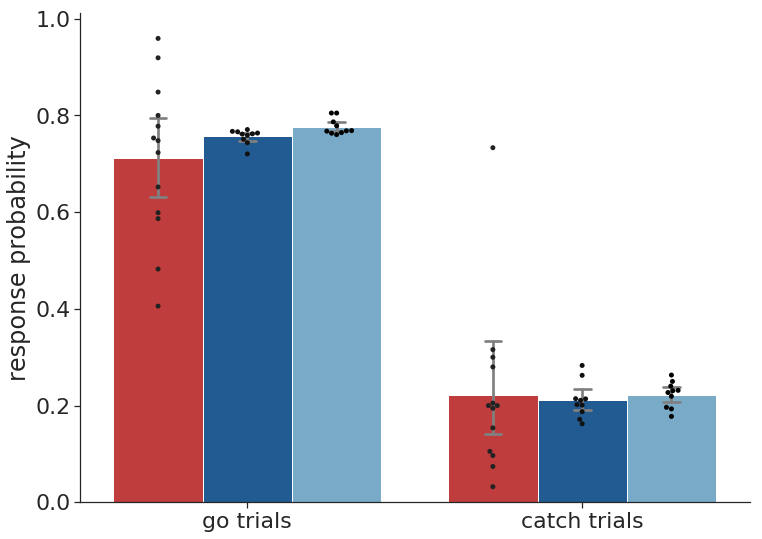

In [15]:
fig, ax = plt.subplots(1,1,figsize=(12,9))

sns.barplot(x='trial_type', y='response_rate', data=df_all, hue='model', palette=[colors[0], colors[1], colors[3]], errcolor='gray', capsize=0.05, ax=ax)
g = sns.swarmplot(x='trial_type', y='response_rate', data=df_all, hue='model', dodge=True, color='black')
g.legend_.remove()

ax.set_xlabel('')
ax.set_ylabel('response probability')

# Hide the right and top spines
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

In [16]:
fig.savefig('figures/response_probability.png', dpi=300, bbox_inches='tight')

# Response probability matrix and matrix asymmetry

In [17]:
def create_resp_prob_heatmap(df, values='response', index='initial_image_name', columns='change_image_name',
                             aggfunc=np.mean, cmap='magma', ax=None, order=None, vmax=1, filter_by_reward_rate=False,
                             analysis_dir=None, reorder=True, title=''):
    if ax is None:
        figsize = (6, 6)
        fig, ax = plt.subplots(figsize=figsize)

    if 'trial_type' in df.keys():
        df = df[df.trial_type != 'aborted']
    if filter_by_reward_rate:
        df = df[df.reward_rate>2]
    response_matrix = pd.pivot_table(df,
                                     values=values,
                                     index=[index],
                                     columns=[columns],
                                     aggfunc=aggfunc)

    if values == 'response':
        vmax = 1
        vmin = 0
        label = 'response probability'
    else:
        vmax = np.amax(np.amax(response_matrix))
        vmin = np.amin(np.amin(response_matrix))
        label = values

    if reorder:
        column_means = []
        for image in response_matrix.keys():
            column_means.append(np.nanmean(response_matrix[response_matrix.index != image][image].values))
        if order is None:
            order = np.argsort(column_means)
        else:
            order = order
        img_order = response_matrix.keys()[order]
        response_matrix.index = pd.CategoricalIndex(response_matrix.index, categories=img_order)
        response_matrix.columns = pd.CategoricalIndex(response_matrix.columns, categories=img_order)
        response_matrix.sortlevel(level=0, inplace=True)
        response_matrix.sortlevel(axis=1, level=0, inplace=True)
        
        # calculate hit and false alarm rate
        rm = response_matrix.values.copy()
        fa_rate = np.diag(rm).mean()
        np.fill_diagonal(rm, np.nan)
        hit_rate = np.nanmean(rm)
        print("hit rate: {0}, false alarm rate: {1}".format(hit_rate, fa_rate))

    ax = sns.heatmap(response_matrix, cmap=cmap, linewidths=0, linecolor='white', square=True, annot=False,
                     annot_kws={"fontsize": 14}, vmin=0, vmax=vmax, robust=True,
                     cbar_kws={"drawedges": False, "shrink": 0.7, 'label': 'response probability'}, ax=ax)

    ax.set_title(title, va='bottom', ha='center')
    ax.set_xlabel(columns)
    ax.set_ylabel(index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    if analysis_dir:
        plt.gcf().subplots_adjust(left=0.32)
        plt.gcf().subplots_adjust(bottom=0.22)
        save_figure(fig, figsize, analysis_dir, 'behavior', title, formats=['.png'])
        
#     fig.savefig('./Slc_response_probability_matrix.png', dpi=300, bbox_inches='tight')

    return ax, response_matrix

In [16]:
def create_resp_prob_heatmap_individual(df, values='response', index='initial_image_name', columns='change_image_name',
                             aggfunc=np.mean, cmap='magma', ax=None, order=None, vmax=1, filter_by_reward_rate=False,
                             analysis_dir=None, reorder=True, title=''):
    if ax is None:
        figsize = (6, 6)
        fig, ax = plt.subplots(figsize=figsize)

    if 'trial_type' in df.keys():
        df = df[df.trial_type != 'aborted']
    if filter_by_reward_rate:
        df = df[df.reward_rate>2]
    response_matrix = pd.pivot_table(df,
                                     values=values,
                                     index=[index],
                                     columns=[columns],
                                     aggfunc=aggfunc)

    if values == 'response':
        vmax = 1
        vmin = 0
        label = 'response probability'
    else:
        vmax = np.amax(np.amax(response_matrix))
        vmin = np.amin(np.amin(response_matrix))
        label = values

    if reorder:
        column_means = []
        for image in response_matrix.keys():
            column_means.append(np.nanmean(response_matrix[response_matrix.index != image][image].values))
        if order is None:
            order = np.argsort(column_means)
        else:
            order = order
        img_order = response_matrix.keys()[order]
        if 'A' in title:  # overwrite for image set A
            img_order = ['im077', 'im062', 'im066', 'im063', 'im065', 'im069', 'im085', 'im061']
        response_matrix.index = pd.CategoricalIndex(response_matrix.index, categories=img_order)
        response_matrix.columns = pd.CategoricalIndex(response_matrix.columns, categories=img_order)
        response_matrix.sortlevel(level=0, inplace=True)
        response_matrix.sortlevel(axis=1, level=0, inplace=True)
        
        # calculate hit and false alarm rate
        rm = response_matrix.values.copy()
        fa_rate = np.nanmean(np.diag(rm))
        np.fill_diagonal(rm, np.nan)
        hit_rate = np.nanmean(rm)
        print("hit rate: {0}, false alarm rate: {1}".format(hit_rate, fa_rate))

    ax = sns.heatmap(response_matrix, cmap=cmap, linewidths=0, linecolor='white', square=True, annot=False,
                     annot_kws={"fontsize": 14}, vmin=0, vmax=vmax, robust=True,
                     cbar_kws={"drawedges": False, "shrink": 0.7, 'label': 'response probability'}, ax=ax)

    ax.set_title(title, va='bottom', ha='center')
    ax.set_xlabel(columns)
    ax.set_ylabel(index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    if analysis_dir:
        plt.gcf().subplots_adjust(left=0.32)
        plt.gcf().subplots_adjust(bottom=0.22)
        save_figure(fig, figsize, analysis_dir, 'behavior', title, formats=['.png'])

    return ax, response_matrix

In [5]:
# load trials df
df = pd.read_hdf(os.path.join(experiment_dir, 'multi_session_summary_dfs', 'multi_session_trials_df.h5'))  # ophys behavior

In [6]:
# select image set A and Slc experiments
df_subset = df[(df.image_set=='A')&(df.cre_line=='Slc17a7-IRES2-Cre')] 

## Experiment response matrices

/home/brianh/miniconda3/envs/vis-behav/lib/python2.7/site-packages/ipykernel_launcher.py:38: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
/home/brianh/miniconda3/envs/vis-behav/lib/python2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)


hit rate: 0.693273751986, false alarm rate: 0.194605771435


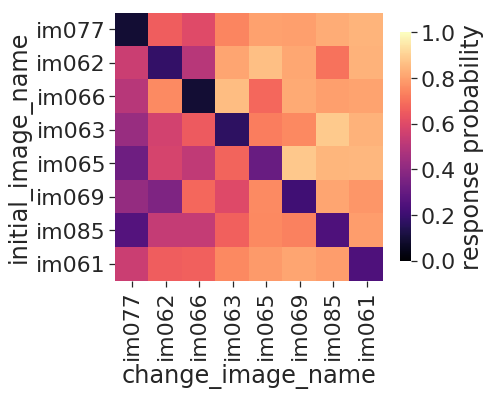

In [18]:
ax, rm = create_resp_prob_heatmap(df_subset, filter_by_reward_rate=True)

## Model response matrices

In [11]:
from mpl_toolkits.axes_grid1 import AxesGrid

In [14]:
for model in ['STSPNet', 'RNN']:
    model_dict[model] = {}
    model_dict[model]['count'] = []
    model_dict[model]['response'] = []
    for seed in range(1,11):
        temp = pickle.load(open(model_dir+model+'/'+model+'_A_'+str(seed)+'.pkl', 'rb'))
        model_dict[model]['count'].append(temp['total_matrix'])
        model_dict[model]['response'].append(temp['response_matrix'])
    model_dict[model]['count'] = np.stack(model_dict[model]['count'])
    model_dict[model]['response'] = np.stack(model_dict[model]['response'])

In [15]:
# model average confusion mat
stspnet_rm_avg = model_dict['STSPNet']['response'].sum(axis=0) / model_dict['STSPNet']['count'].sum(axis=0)
rnn_rm_avg = model_dict['RNN']['response'].sum(axis=0) / model_dict['STSPNet']['count'].sum(axis=0)

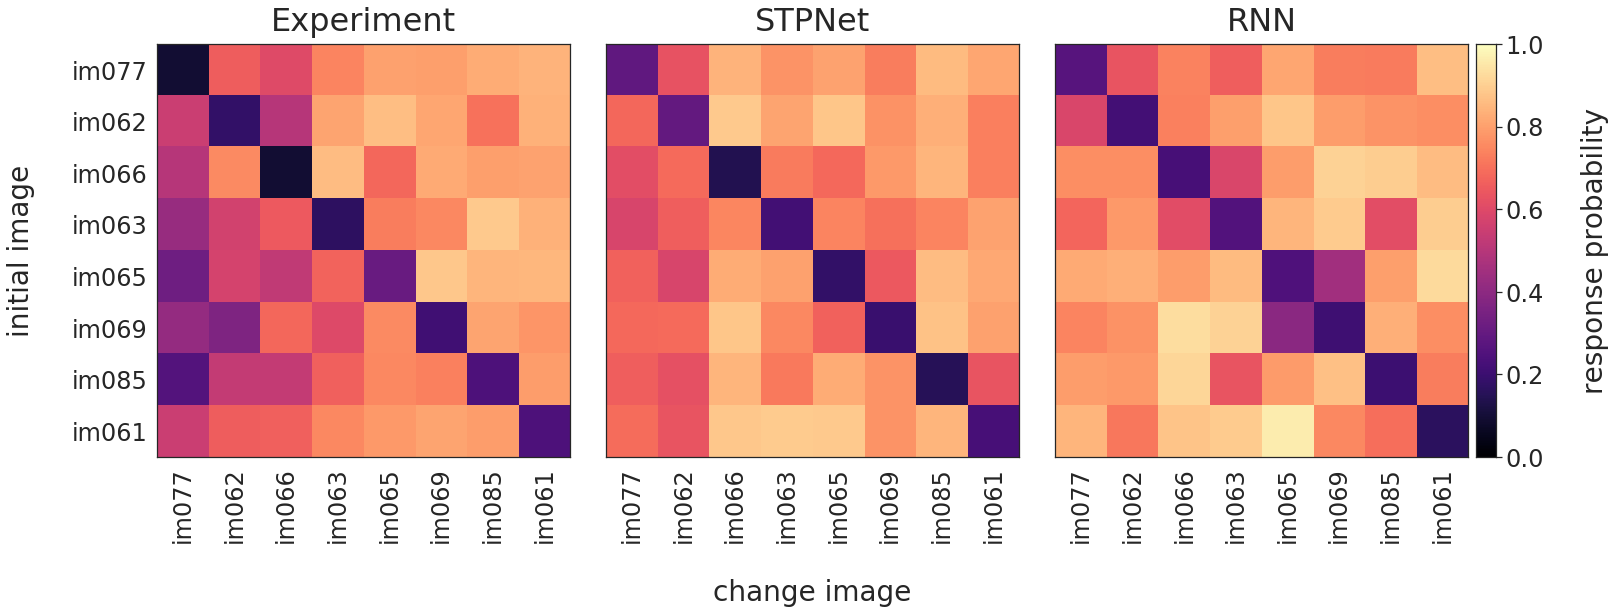

In [19]:
sns.set_style({'xtick.bottom': False, 'ytick.left': False,})
# sns.set_style('white', {'xtick.bottom': True, 'ytick.left': True})
# sns.set_context('notebook', font_scale=2)

# based on experimental detectability
img_order = ['im077', 'im062', 'im066', 'im063', 'im065', 'im069', 'im085', 'im061']

fig = plt.figure(figsize=(24, 8))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.5,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

# individual response prob matrices
grid[0].imshow(rm, cmap='magma', vmin=0, vmax=1)
grid[0].set_xticks(np.arange(8))
grid[0].set_xticklabels(img_order, rotation=90, fontsize=24)
grid[0].set_yticks(np.arange(8))
grid[0].set_yticklabels(img_order, fontsize=24)
grid[0].set_ylabel('initial image\n', fontsize=28)
grid[0].spines['top'].set_visible(True)
grid[0].spines['right'].set_visible(True)
grid[0].set_title('Experiment', va='bottom', ha='center', fontsize=32)

grid[1].imshow(stspnet_rm_avg, cmap='magma', vmin=0, vmax=1)
grid[1].set_xticks(np.arange(8))
grid[1].set_xticklabels(img_order, rotation=90, fontsize=24)
grid[1].set_xlabel('\nchange image', fontsize=28)
grid[1].spines['top'].set_visible(True)
grid[1].spines['right'].set_visible(True)
grid[1].set_title('STPNet', va='bottom', ha='center', fontsize=32)

im = grid[2].imshow(rnn_rm_avg, cmap='magma', vmin=0, vmax=1)
grid[2].set_xticks(np.arange(8))
grid[2].set_xticklabels(img_order, rotation=90, fontsize=24)
grid[2].spines['top'].set_visible(True)
grid[2].spines['right'].set_visible(True)
grid[2].set_title('RNN', va='bottom', ha='center', fontsize=32)

# colorbar
cbar = grid.cbar_axes[0].colorbar(im)
cbar.ax.tick_params(labelsize=24)
cbar.ax.spines['right'].set_visible(True)
cbar.set_label_text('\nresponse probability', fontsize=28)

In [61]:
fig.savefig('figures/image_set_A_rm.png', dpi=300, bbox_inches='tight')

# Correlation between response matrices

In [16]:
from scipy.stats import pearsonr

In [17]:
# Experiment to STPNet
pearsonr(rm.values.flatten(), stspnet_rm_avg.flatten())

(0.7913249491077697, 7.139483124212568e-15)

In [18]:
# Experiment to RNN
pearsonr(rm.values.flatten(), rnn_rm_avg.flatten())

(0.6464322741936538, 7.942915778325922e-09)

# Compute individual response matrices

/home/brianh/miniconda3/envs/vis-behav/lib/python2.7/site-packages/ipykernel_launcher.py:40: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
/home/brianh/miniconda3/envs/vis-behav/lib/python2.7/site-packages/ipykernel_launcher.py:41: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)


hit rate: 0.4125, false alarm rate: 0.0729166666667
hit rate: 0.856547619048, false alarm rate: 0.191666666667
hit rate: 0.794642857143, false alarm rate: 0.2
hit rate: 0.955357142857, false alarm rate: 0.28125
hit rate: 0.72619047619, false alarm rate: 0.03125
hit rate: 0.692307692308, false alarm rate: 0.357142857143
hit rate: 0.59494047619, false alarm rate: 0.09375
hit rate: 0.77380952381, false alarm rate: 0.333333333333
hit rate: 0.606845238095, false alarm rate: 0.15625
hit rate: 0.478273809524, false alarm rate: 0.2125
hit rate: 0.778273809524, false alarm rate: 0.125
hit rate: 0.907407407407, false alarm rate: 0.791666666667
hit rate: 0.75, false alarm rate: 0.208333333333


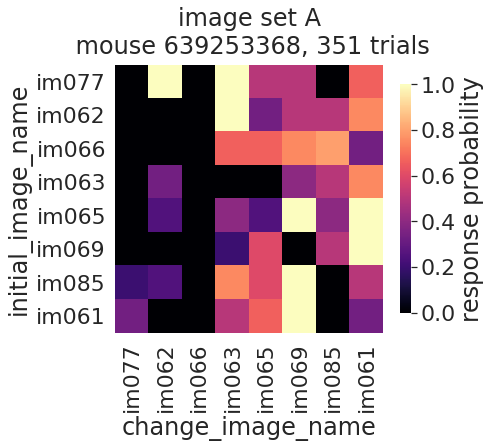

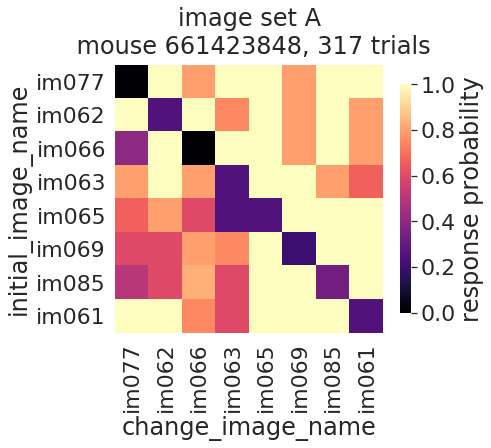

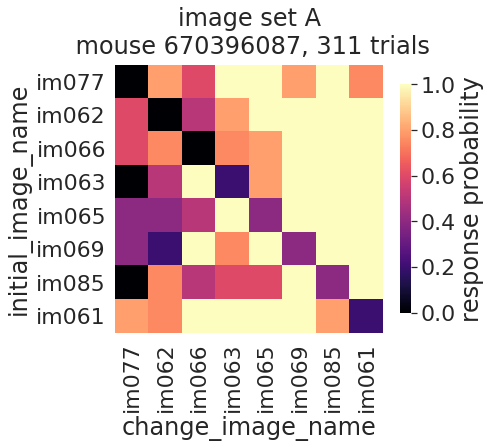

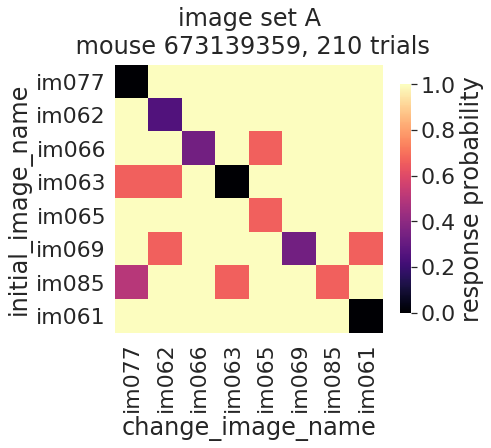

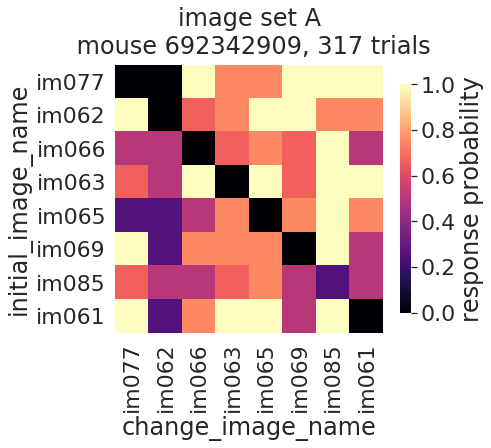

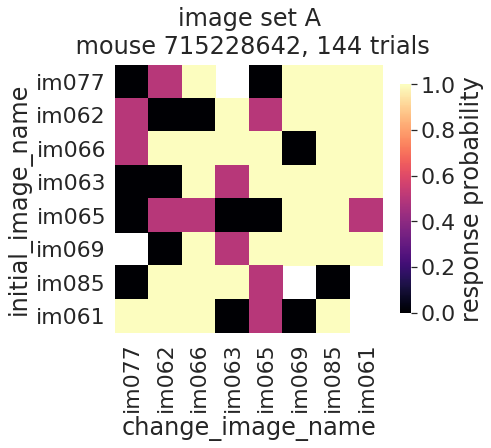

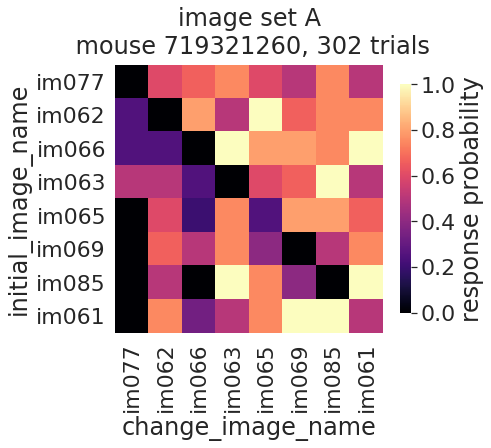

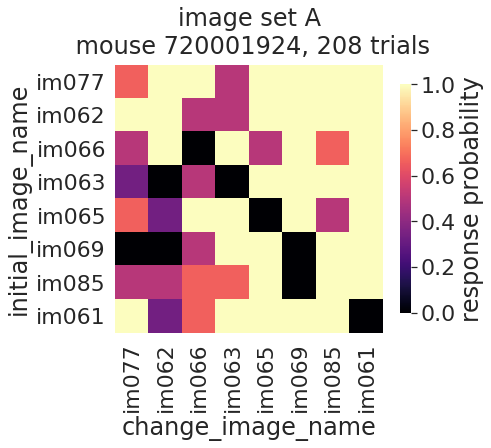

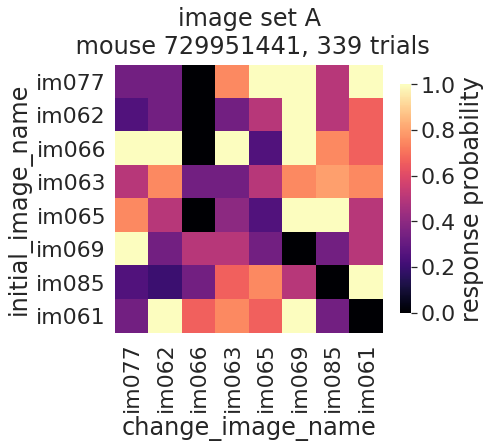

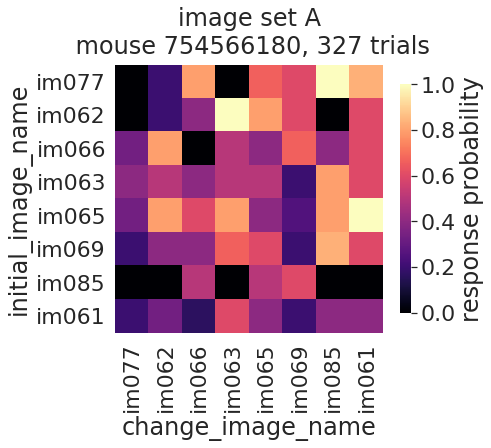

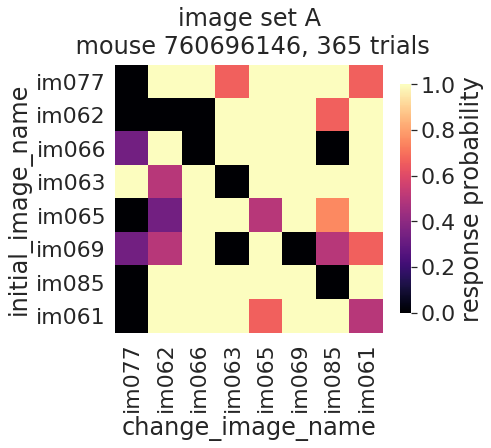

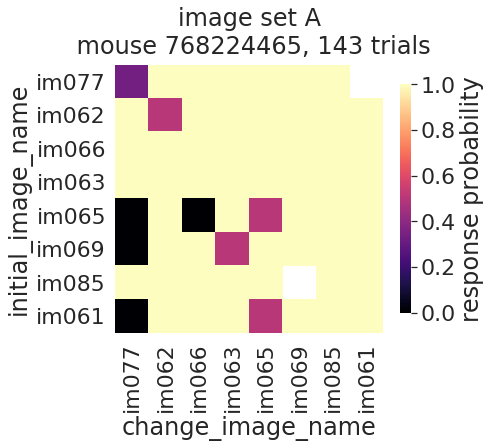

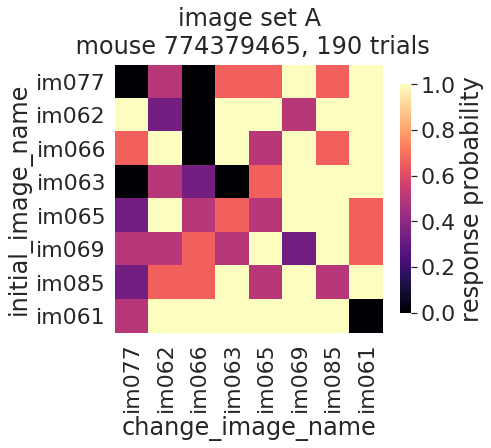

In [20]:
rm_all = []
for exp in df_subset.experiment_id.unique():
    tmp = df_subset[df_subset.experiment_id==exp]
    title = 'image set A'+'\n mouse '+str(exp)+', '+str(len(tmp))+' trials'
    ax, rm = create_resp_prob_heatmap_individual(tmp, filter_by_reward_rate=True, title=title)
    rm_all.append(rm)

In [21]:
rm_all = np.stack(rm_all)

# Compute matrix asymmetry value

Note: mean shift is important for capturing negative assymmetry values!
This is automatically "done" using Doug's pearson correlation method

In [22]:
# Source: https://math.stackexchange.com/questions/2048817/metric-for-how-symmetric-a-matrix-is
def compute_matrix_asymmetry(matrix, mean_shift=False):
    """
    matrix: input response probability matrix

    returns a measure of matrix asymmetry:
    Q = ||M_sym - M_antisym|| / ||M_sym + M_antisym||
    """
    matrix_copy = matrix.copy()

    if mean_shift:
        np.fill_diagonal(matrix_copy, np.nan)
        matrix_copy -= np.nanmean(matrix_copy)

    np.fill_diagonal(matrix_copy, 0)
    
    # compute symmetric and anti-symmetric matrices
    # Be careful of floating point for python 2
    matrix_sym = 1./2 * (matrix_copy + matrix_copy.T)
    matrix_asym = 1./2 * (matrix_copy - matrix_copy.T)
    
    # Remove potential nans
    matrix_sym = np.nan_to_num(matrix_sym)
    matrix_asym = np.nan_to_num(matrix_asym)

    symmetry = (np.linalg.norm(matrix_sym) - np.linalg.norm(matrix_asym)) / \
        (np.linalg.norm(matrix_sym) + np.linalg.norm(matrix_asym))

    return symmetry

In [65]:
# Based on Doug's notebook here: https://nbviewer.jupyter.org/gist/dougollerenshaw/680ba0de66660475ac875e55d5056866
def compute_matrix_asymmetry_doug(matrix, include_diagonal=True):
    
    matrix_copy = matrix.copy()
    
    # correlation of rows vs columns
    if not include_diagonal:
        np.fill_diagonal(matrix_copy, np.nan)
        
    corr_coeff = pearsonr(np.nanmean(matrix_copy, axis=0), np.nanmean(matrix_copy, axis=1))

    return corr_coeff[0]

In [23]:
experiment_Q = [compute_matrix_asymmetry(m, mean_shift=True) for m in rm_all]
# experiment_Q = [compute_matrix_asymmetry_doug(m) for m in rm_all]

In [24]:
stspnet_rm_all = [response / count for response, count in zip(model_dict['STSPNet']['response'], model_dict['STSPNet']['count'])]
rnn_rm_all = [response / count for response, count in zip(model_dict['RNN']['response'], model_dict['RNN']['count'])]

stspnet_Q = [compute_matrix_asymmetry(m, mean_shift=True) for m in stspnet_rm_all]
rnn_Q = [compute_matrix_asymmetry(m, mean_shift=True) for m in rnn_rm_all]

# stspnet_Q = [compute_matrix_asymmetry_doug(m) for m in stspnet_rm_all]
# rnn_Q = [compute_matrix_asymmetry_doug(m) for m in rnn_rm_all]

In [25]:
# create one dataframe
exp_df = pd.DataFrame({'model': 'Experiment', 'matrix_asymmetry': experiment_Q})
stspnet_df = pd.DataFrame({'model': 'STPNet', 'matrix_asymmetry': stspnet_Q})
rnn_df = pd.DataFrame({'model': 'RNN', 'matrix_asymmetry': rnn_Q})

df_all = pd.concat((exp_df, stspnet_df, rnn_df), ignore_index=True)

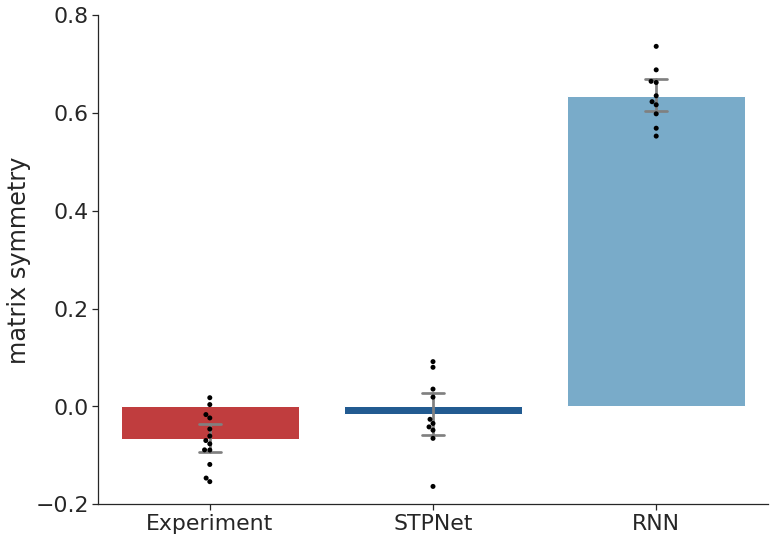

In [26]:
sns.set_style({'xtick.bottom': True, 'ytick.left': True,})

fig, ax = plt.subplots(1,1,figsize=(12,9))

sns.barplot(x='model', y='matrix_asymmetry', data=df_all, palette=[colors[0],colors[1],colors[3]], errcolor='gray', capsize=0.1, ax=ax)
sns.swarmplot(x='model', y='matrix_asymmetry', data=df_all, color='black', ax=ax)

ax.set_xlabel('')
ax.set_ylabel('matrix symmetry')
ax.set_ylim([-0.2, 0.8])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [74]:
fig.savefig('figures/matrix_symmetry.png', dpi=300, bbox_inches='tight')

In [49]:
df_all.groupby('model').agg([np.mean, np.std])

matrix_asymmetry          
                       mean       std
model                                
Experiment        -0.066716  0.053745
RNN                0.634487  0.055438
STPNet            -0.015367  0.075291